## Сегментация изображений

# К сожалению не смог улучшить или как-то оптимизировать данную модель, т.к. потрартил много времени на разбор кода, но я, всё-таки разобрался, как это работает

In [ ]:
! pip install opencv-python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import PIL
from IPython.display import clear_output

## Загрузка датасета  
Для задачи сегментации изображений мы будем использовать "Базу данных для домашних животных Oxford-IIITt", которая доступна для бесплатного использования dataset. У них есть набор данных 37 категорий pet, содержащий примерно 200 изображений для каждого класса. Изображения сильно различаются по масштабу, позе и освещению. Все изображения имеют соответствующую аннотацию о сегментации карты обрезки на уровне пикселей. Каждый пиксель классифицируется в одну из трех категорий:

- Пиксель, принадлежащий домашнему животному
- Пиксель, граничащий с домашним животным
- Пиксель не относится ни к классу 1, ни ко 2

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Сначала мы нормализуем значения пикселей в диапазоне [0,1]. Для этого мы разделим значение каждого пикселя на 255. Пиксели сегментационной маски будут помечены {1, 2, 3}, но для удобства из данного цифрового ряда будет вычтено по 1 и в итоге получиться {0, 1, 2}. Набор данных, включенный из TensorFlow, уже разделен на обучающий и тестовый сплит.

Функция для создания обучающего датасета аугументируют данные используя поворот

In [3]:
def normalize(input_image, input_mask):

	# Normalize the pixel range values between [0:1]
	img = tf.cast(input_image, dtype=tf.float32) / 255.0 # tf.cast приводит тензор к новому типу.
	input_mask -= 1
	return img, input_mask

@tf.function
def load_train_ds(dataset):
	img = tf.image.resize(dataset['image'],
						size=(width, height))
	mask = tf.image.resize(dataset['segmentation_mask'],
						size=(width, height))

	if tf.random.uniform(()) > 0.5:
		img = tf.image.flip_left_right(img)
		mask = tf.image.flip_left_right(mask)

	img, mask = normalize(img, mask)
	return img, mask

@tf.function
def load_test_ds(dataset):
	img = tf.image.resize(dataset['image'],
						size=(width, height))
	mask = tf.image.resize(dataset['segmentation_mask'],
						size=(width, height))

	img, mask = normalize(img, mask)
	return img, mask


Теперь мы установим некоторые постоянные значения, такие как размер буфера, высота и ширина ввода и т.д.

In [4]:
TRAIN_LENGTH = info.splits['train'].num_examples

# Batch size is the number of examples used in one training example.
# It is mostly a power of 2
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# For VGG16 this is the input size
width, height = 224, 224


![An image](https://neurohive.io/wp-content/uploads/2018/11/vgg16-neural-network-1.jpg )

Теперь давайте загрузим обучающие и тестовые данные в разные переменные и выполним увеличение данных после завершения пакетной обработки.

Как сократить время обучения модели глубокого обучения с помощью tf.data:
Вы можете найти количество ядер на машине и указать это, но лучший вариант - делегировать уровень параллелизма tf.data с помощью
# tf.data.experimental.AUTOTUNE.

- AUTOTUNE попросит tf.data динамически настроить значение во время выполнения.
- tf.data найдет правильный бюджет ЦП для всех настраиваемых операций.
- AUTOTUNE определяет уровень параллелизма для размера буфера, бюджета ЦП, а также для операций ввода-вывода.  

1. `cache ()`
позволяет кэшировать данные в указанном файле или в памяти.

- При кэшировании в памяти при первой итерации данные будут кэшироваться, а при всех последующих итерациях данные будут считываться из кеша.
- При кэшировании файла даже данные первой итерации будут считаны из кешированного файла.
- Кэширование создает одни и те же элементы для каждой итерации, используйте shuffle () для рандомизации элементов в итерациях после кэширования данных.

2. `prefetch`: Операция `prefetch` позволяет параллельно подгружать следующие элементы датасета, тогда как текущий элемент уже обрабатывается. Это может улучшить скорость обучения, так как GPU может продолжать работу, не ожидая следующий элемент данных.

3. `interleave`: Операция `interleave` позволяет объединить несколько датасетов в один путем интерлевирования элементов из этих датасетов. Например, можно объединить датасеты изображений и датасеты меток, чтобы получить датасет, содержащий пары изображений и меток.

4. `batch`: Операция `batch` позволяет объединить несколько элементов датасета в один батч. Например, можно объединить несколько изображений в один батч для эффективной обработки параллельно.

5. `repeat`: Операция `repeat` позволяет повторять датасет несколько раз. Например, если в датасете есть 100 изображений, то операция `repeat(2)` создаст датасет, содержащий 200 изображений.

6. `shuffle`: Операция `shuffle` позволяет перемешать элементы в датасете с помощью заданного размера буфера. Например, `shuffle(100)` перемешает элементы датасета с использованием буфера размером 100.


In [5]:
train = dataset['train'].map(
	load_train_ds, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_test_ds)

train_ds = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.batch(BATCH_SIZE)

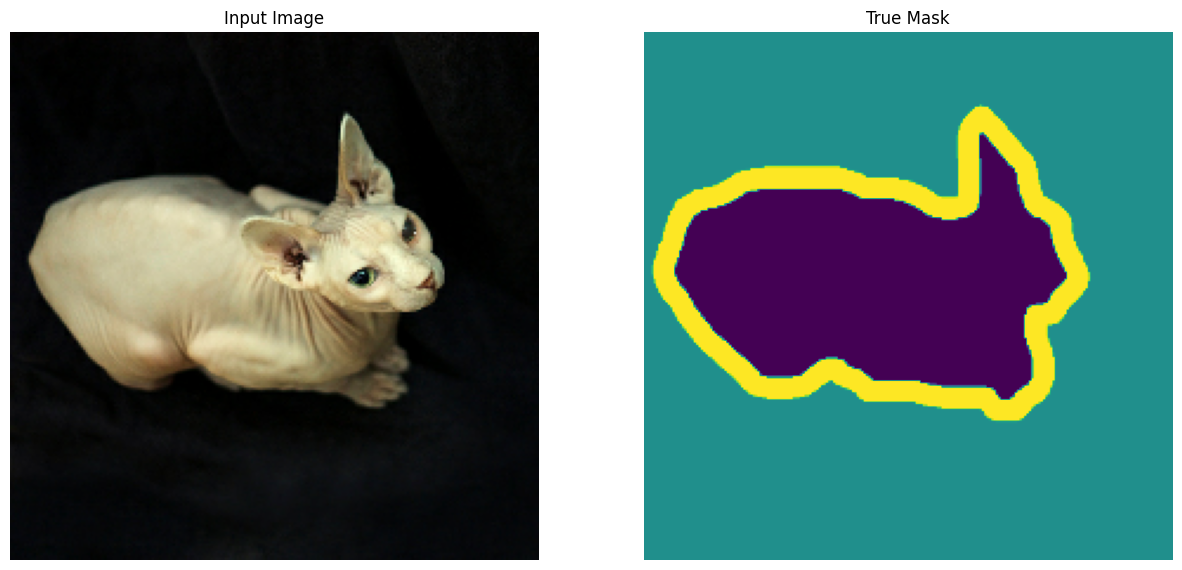

In [6]:
def display_images(display_list):
	plt.figure(figsize=(15, 15))
	title = ['Input Image', 'True Mask',
			'Predicted Mask']

	for i in range(len(display_list)):
		plt.subplot(1, len(display_list), i+1)
		plt.title(title[i])
		plt.imshow(keras.preprocessing.image.array_to_img(display_list[i]))
		plt.axis('off')

	plt.show()


for img, mask in train.take(1):
	sample_image, sample_mask = img, mask
	display_list = sample_image, sample_mask

display_images(display_list)


## U-Net
U-Net - это архитектура CNN, используемая для большинства задач сегментации. Она состоит из пути сжатия и расширения, что дает ей название UNet. Путь сжатия состоит из слоя свертки, за которым следует ReLU, за которым следуют слои с максимальным объединением. По пути сжатия объекты извлекаются и пространственная информация уменьшается. По пути расширения выполняется серия сверток вверх вместе с объединением объектов с близким разрешением по пути сжатия.

![An image](https://neurohive.io/wp-content/uploads/2018/11/U-net-neural-network-medicine-768x512-1-570x380.png)

Для этого проекта мы будем использовать кодировщик модели VGG16, поскольку он уже обучен работе с набором данных ImageNet и изучил некоторые функции. Если используется оригинальный кодировщик UNet, он будет изучать все с нуля и займет больше времени.

In [ ]:

base_model = keras.applications.vgg16.VGG16(
    include_top=False, input_shape=(width, height, 3))

layer_names = [
    'block1_pool',
    'block2_pool',
    'block3_pool',
    'block4_pool',
    'block5_pool',
]
base_model_outputs = [base_model.get_layer(
    name).output for name in layer_names]
base_model.trainable = False

VGG_16 = tf.keras.models.Model(base_model.input,
                               base_model_outputs)

58889256/58889256 [==============================] - 0s 0us/step


Теперь определите декодер

In [ ]:
def fcn8_decoder(convs, n_classes):
	f1, f2, f3, f4, p5 = convs

	n = 4096
	c6 = tf.keras.layers.Conv2D(
		n, (7, 7), activation='relu', padding='same',
	name="conv6")(p5)
	c7 = tf.keras.layers.Conv2D(
		n, (1, 1), activation='relu', padding='same',
	name="conv7")(c6)

	f5 = c7

	# upsample the output of the encoder
	# then crop extra pixels that were introduced
	o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(
		4, 4), strides=(2, 2), use_bias=False)(f5)
	o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

	# load the pool 4 prediction and do a 1x1
	# convolution to reshape it to the same shape of `o` above
	o2 = f4
	o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1),
								activation='relu',
								padding='same'))(o2)

	# add the results of the upsampling and pool 4 prediction
	o = tf.keras.layers.Add()([o, o2])

	# upsample the resulting tensor of the operation you just did
	o = (tf.keras.layers.Conv2DTranspose(
		n_classes, kernel_size=(4, 4), strides=(2, 2),
	use_bias=False))(o)
	o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

	# load the pool 3 prediction and do a 1x1
	# convolution to reshape it to the same shape of `o` above
	o2 = f3
	o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1),
								activation='relu',
								padding='same'))(o2)

	# add the results of the upsampling and pool 3 prediction
	o = tf.keras.layers.Add()([o, o2])

	# upsample up to the size of the original image
	o = tf.keras.layers.Conv2DTranspose(
		n_classes, kernel_size=(8, 8), strides=(8, 8),
	use_bias=False)(o)

	# append a softmax to get the class probabilities
	o = tf.keras.layers.Activation('softmax')(o)
	return o

Объединение всего, создание окончательной модели и ее компиляция

In [ ]:
def segmentation_model():

	inputs = keras.layers.Input(shape=(width, height, 3))
	convs = VGG_16(inputs)
	outputs = fcn8_decoder(convs, 3)
	model = tf.keras.Model(inputs=inputs, outputs=outputs)

	return model

In [ ]:

opt = keras.optimizers.Adam()

model = segmentation_model()
model.compile(optimizer=opt,
			loss=tf.keras.losses.SparseCategoricalCrossentropy(
				from_logits=True),
			metrics=['accuracy'])


Утилита создания маски прогнозирования

In [7]:
def create_mask(pred_mask):
	pred_mask = tf.argmax(pred_mask, axis=-1)
	pred_mask = pred_mask[..., tf.newaxis]
	return pred_mask[0]


def show_predictions(Model, dataset=None, num=1):
	if dataset:
		for image, mask in dataset.take(num):
			pred_mask = Model.predict(image)
			display_images([image[0], mask[0], create_mask(pred_mask)])
	else:
		display_images([sample_image, sample_mask,
						create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
show_predictions(Model=model)

# Обучение  
Теперь, когда все необходимые функции вместе с моделью созданы, мы будем обучать модель. Мы будем обучать модель в течение 20 эпох и выполним разделение проверки на 5.

In [8]:
EPOCHS = 20
VAL_SUBSPLITS = 5

In [9]:
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

In [17]:
VALIDATION_STEPS

11

In [ ]:
model_history = model.fit(train_ds, epochs=EPOCHS,
						steps_per_epoch=STEPS_PER_EPOCH,
						validation_steps=VALIDATION_STEPS,
						validation_data=test_ds)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


57/57 [==============================] - 67s 786ms/step - loss: 1.0804 - accuracy: 0.4024 - val_loss: 0.8184 - val_accuracy: 0.5682
Epoch 2/20
57/57 [==============================] - 60s 909ms/step - loss: 0.5983 - accuracy: 0.7279 - val_loss: 0.4829 - val_accuracy: 0.8021
Epoch 3/20
57/57 [==============================] - 51s 894ms/step - loss: 0.4358 - accuracy: 0.8201 - val_loss: 0.4317 - val_accuracy: 0.8181
Epoch 4/20
57/57 [==============================] - 51s 897ms/step - loss: 0.3896 - accuracy: 0.8338 - val_loss: 0.4257 - val_accuracy: 0.8195
Epoch 5/20
57/57 [==============================] - 51s 895ms/step - loss: 0.3611 - accuracy: 0.8420 - val_loss: 0.4138 - val_accuracy: 0.8250
Epoch 6/20
57/57 [==============================] - 46s 814ms/step - loss: 0.3411 - accuracy: 0.8479 - val_loss: 0.4154 - val_accuracy: 0.8285
Epoch 7/20
57/57 [==============================] - 46s 812ms/step - loss: 0.3200 - accuracy: 0.8551 - val_loss: 0.4216 - val_accuracy: 0.8270
Epoch 8/20

Для задачи сегментации рассматриваются 2 типа показателей.
Формулы для каждого из них следующие:  
Intersection-Over-Union (IoU)

IoU - это область перекрытия между прогнозируемой сегментацией и реальной маской, разделенная объединением двух.  
DiceScore   
Проще говоря, коэффициент кубика равен 2 * площадь перекрытия, деленная на общее количество пикселей в обоих изображениях

![An image](https://i2.wp.com/miro.medium.com/0*kraYHnYpoJOhaMzq.png)

![An image](https://i2.wp.com/miro.medium.com/1*yUd5ckecHjWZf6hGrdlwzA.png)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 112, 112, 64),       1471468   ['input_2[0][0]']             
                              (None, 56, 56, 128),        8                                       
                              (None, 28, 28, 256),                                                
                              (None, 14, 14, 512),                                                
                              (None, 7, 7, 512)]                                                  
                                                                                            

In [ ]:
model.save('drive/MyDrive/My_folder/')

После сохранения модел мне пришлось переподключаться к colab т.к. на обучение были потрачены все свободные ячейки GPU модуля

In [10]:
my_model = keras.models.load_model('drive/MyDrive/My_folder')

In [11]:
my_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 112, 112, 64),       1471468   ['input_2[0][0]']             
                              (None, 56, 56, 128),        8                                       
                              (None, 28, 28, 256),                                                
                              (None, 14, 14, 512),                                                
                              (None, 7, 7, 512)]                                                  
                                                                                            

In [12]:
def compute_metrics(y_true, y_pred):
	'''
	Computes IOU and Dice Score.

	Args:
	y_true (tensor) - ground truth label map
	y_pred (tensor) - predicted label map
	'''

	class_wise_iou = []
	class_wise_dice_score = []

	smoothening_factor = 0.00001

	for i in range(3):
		intersection = np.sum((y_pred == i) * (y_true == i))
		y_true_area = np.sum((y_true == i))
		y_pred_area = np.sum((y_pred == i))
		combined_area = y_true_area + y_pred_area

		iou = (intersection + smoothening_factor) / \
			(combined_area - intersection + smoothening_factor)
		class_wise_iou.append(iou)

		dice_score = 2 * ((intersection + smoothening_factor) /
						(combined_area + smoothening_factor))
		class_wise_dice_score.append(dice_score)

	return class_wise_iou, class_wise_dice_score


## Прогнозирование модели с помощью метрик

In [13]:
def get_test_image_and_annotation_arrays():
	'''
	Unpacks the test dataset and returns
	the input images and segmentation masks
	'''

	ds = test_ds.unbatch()
	ds = ds.batch(info.splits['test'].num_examples)

	images = []
	y_true_segments = []

	for image, annotation in ds.take(1):
		y_true_segments = annotation.numpy()
		images = image.numpy()

	y_true_segments = y_true_segments[:(
		info.splits['test'].num_examples - (info.splits['test']
											.num_examples % BATCH_SIZE))]
	images = images[:(info.splits['test'].num_examples -
					(info.splits['test'].num_examples % BATCH_SIZE))]

	return images, y_true_segments


In [14]:
y_true_images, y_true_segments = get_test_image_and_annotation_arrays()

integer_slider = 2574
img = np.reshape(y_true_images[integer_slider], (1, width, height, 3))
y_pred_mask = my_model.predict(img)
y_pred_mask = create_mask(y_pred_mask)
y_pred_mask.shape

1/1 [==============================] - 9s 9s/step


TensorShape([224, 224, 1])

In [15]:

def display_prediction(display_list, display_string):
	plt.figure(figsize=(15, 15))
	title = ['Input Image', 'True Mask', 'Predicted Mask']

	for i in range(len(display_list)):
		plt.subplot(1, len(display_list), i+1)
		plt.title(title[i])
		plt.xticks([])
		plt.yticks([])
		if i == 1:
			plt.xlabel(display_string, fontsize=12)
		plt.imshow(keras.preprocessing.image.array_to_img(display_list[i]))
	plt.show()



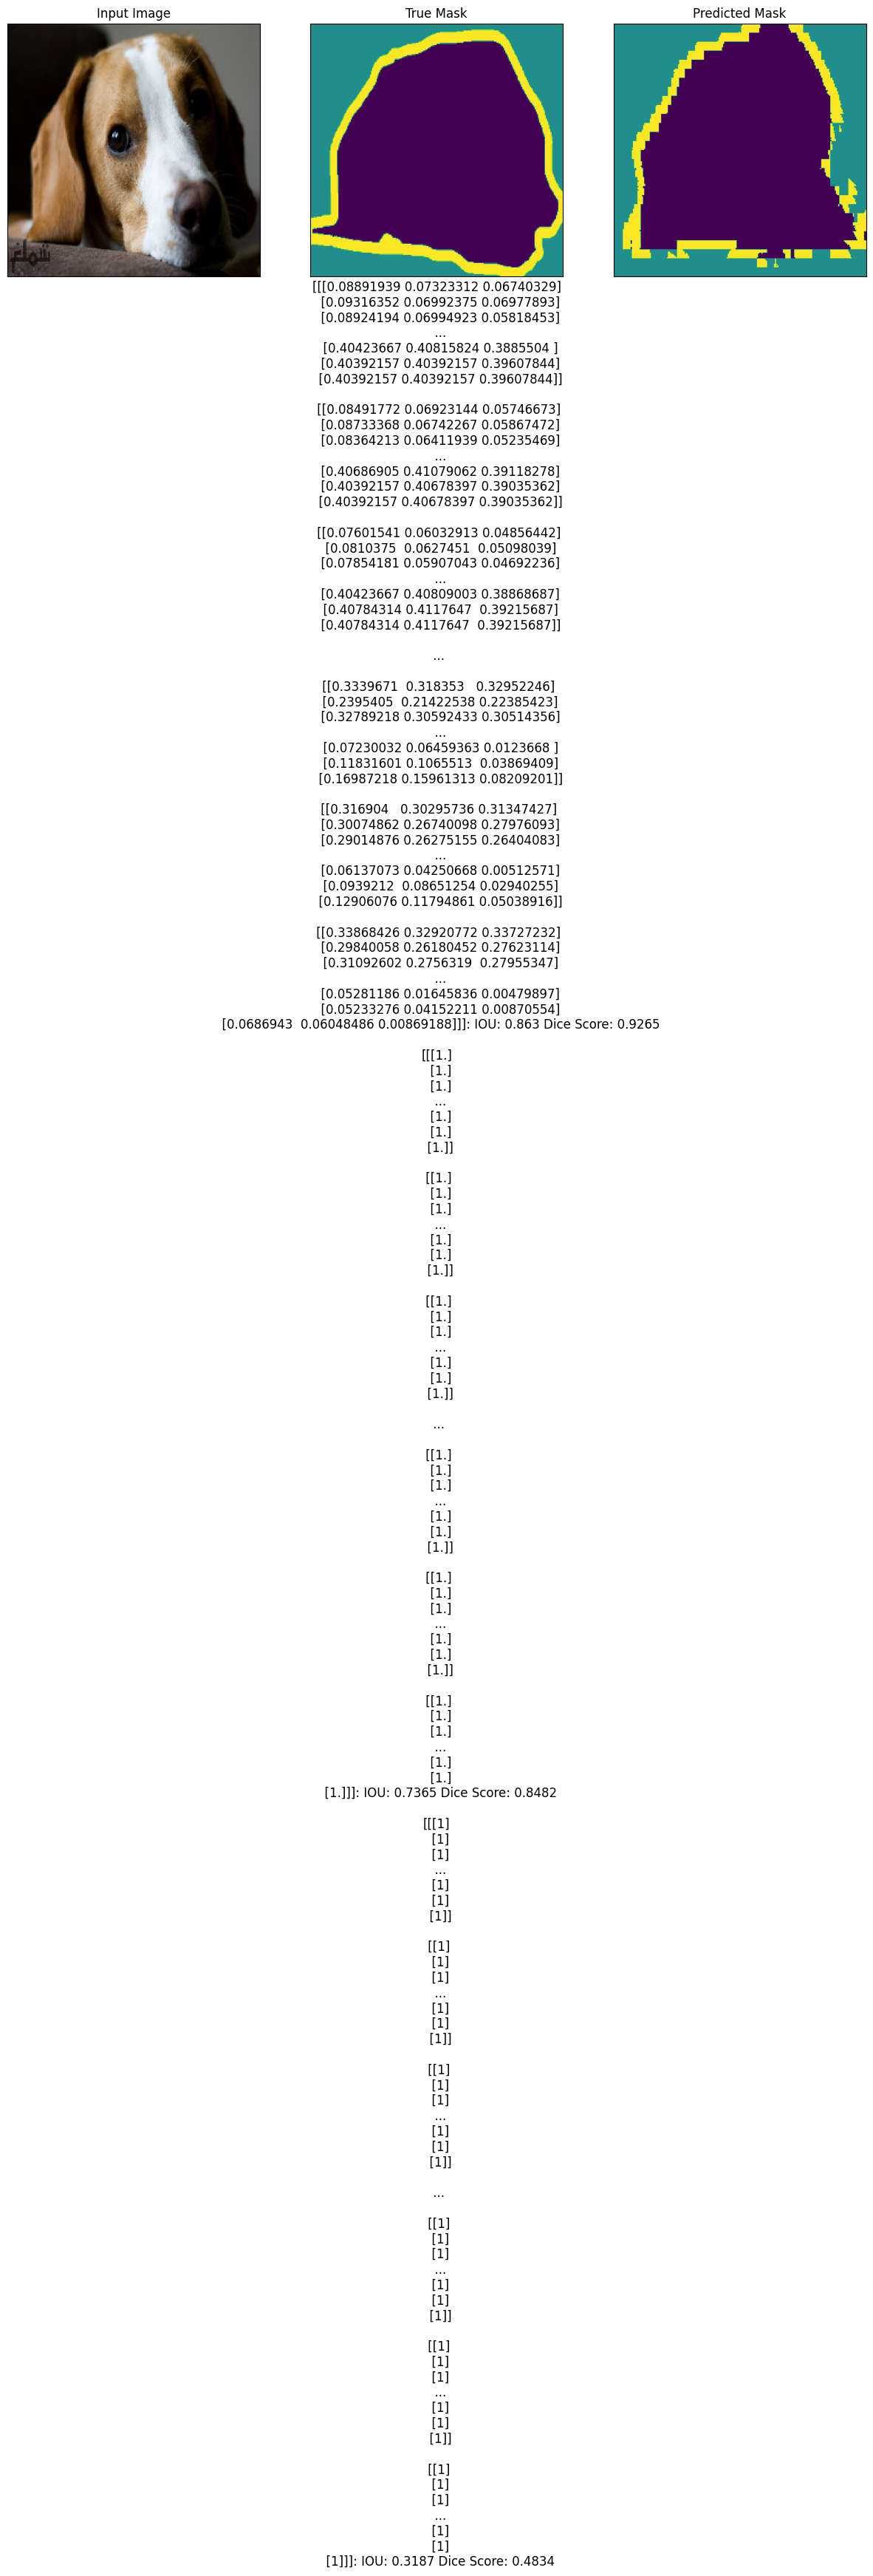

In [16]:
iou, dice_score = compute_metrics(
	y_true_segments[integer_slider], y_pred_mask.numpy())
display_list = [y_true_images[integer_slider],
				y_true_segments[integer_slider], y_pred_mask]

display_string_list = ["{}: IOU: {} Dice Score: {}".format(display_list[idx],
														i, dc) for idx, (i, dc) in
					enumerate(zip(np.round(iou, 4), np.round(dice_score, 4)))]
display_string = "\n\n".join(display_string_list)


# showing predictions with metrics
display_prediction(display_list, display_string)
